In [1]:
import os
import sys

os.chdir("../")

from ISP.utils import *
import rawpy
import cv2
import torch
import matplotlib.pyplot as plt

def viz_two_images(img1, img2, title1, title2):
    fig = plt.figure(figsize=(16, 16))
    rows = 1; cols = 2

    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.set_title(title1)
    
    if len(img1.shape) == 2:
        image1 = ax1.imshow(img1, 'gray')
    else:
        image1 = ax1.imshow(img1)

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.set_title(title2)
    
    if len(img2.shape) == 2:
        image2 = ax2.imshow(img2, 'gray')
    else:
        image2 = ax2.imshow(img2)
    fig.tight_layout()
    plt.show()
demosaic = Demosaic()

# Read raw image and sRGB image

In [2]:
raw_path = os.path.join('notebooks/samples', 'CLN00001.ARW')
raw = rawpy.imread(raw_path)
a7r3_raw = raw.raw_image_visible.copy()
a7r3_raw = a7r3_raw[8:-8, 8:-8]

srgb_path = os.path.join('notebooks/samples', 'CLN00001.JPG')
a7r3_srgb = cv2.imread(srgb_path, cv2.IMREAD_COLOR).astype('float32')/255
a7r3_srgb = cv2.cvtColor(a7r3_srgb, cv2.COLOR_BGR2RGB)

In [3]:
# numpy to torch tensor
a7r3_raw_pt = torch.from_numpy(a7r3_raw.copy().astype('float32'))

red = a7r3_raw_pt[0::2, 0::2]
green_red = a7r3_raw_pt[0::2, 1::2]
green_blue = a7r3_raw_pt[1::2, 0::2]
blue = a7r3_raw_pt[1::2, 1::2]

img_raw = torch.stack([red, green_red, green_blue, blue], dim=2)

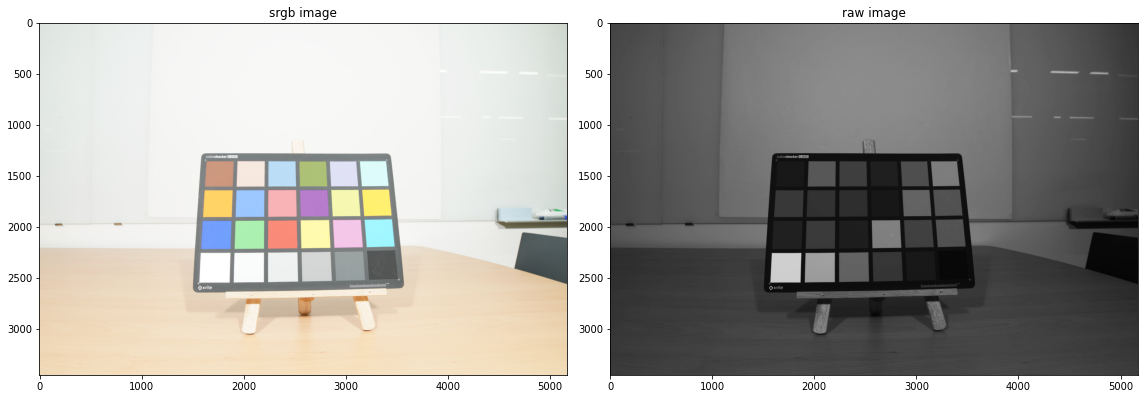

In [4]:
viz_two_images(a7r3_srgb, a7r3_raw, 'srgb image', 'raw image')

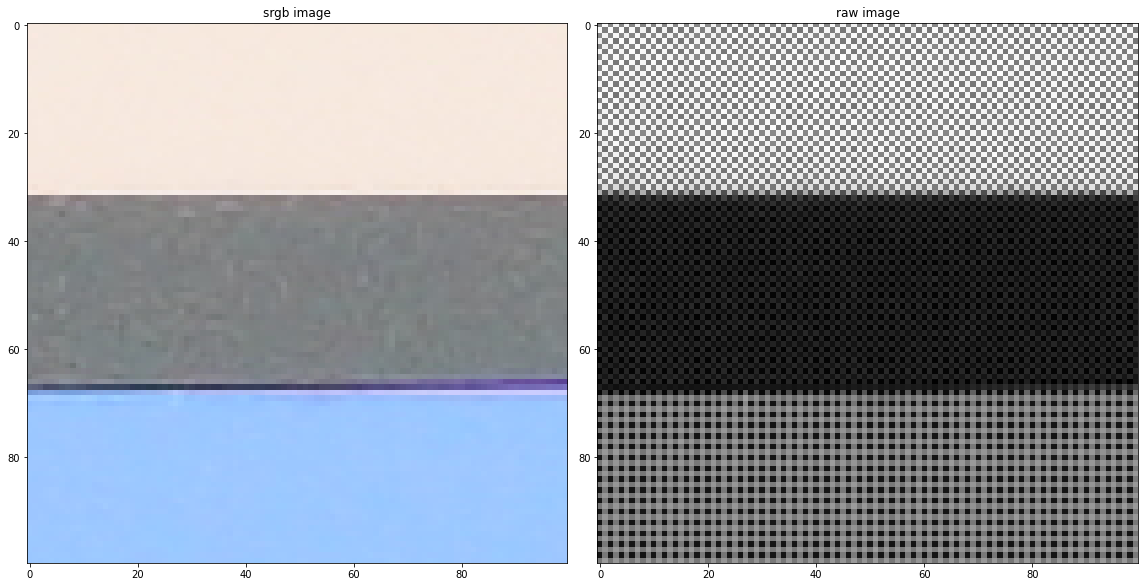

In [5]:
viz_two_images(a7r3_srgb[1570:1670, 2070:2170,:], a7r3_raw[1570:1670, 2070:2170], 'srgb image', 'raw image')

# Black and white level normalization



In [6]:
a7r3_raw.min(), a7r3_raw.max()

(598, 16383)

In [7]:
#! apt-get install exiftool 
!exiftool notebooks/samples/CLN00007.ARW

ExifTool Version Number         : 10.80
File Name                       : CLN00007.ARW
Directory                       : notebooks/samples
File Size                       : 35 MB
File Modification Date/Time     : 2021:10:30 07:13:22+09:00
File Access Date/Time           : 2023:08:06 07:23:17+09:00
File Inode Change Date/Time     : 2023:08:04 09:08:56+09:00
File Permissions                : rwxrwxrwx
File Type                       : ARW
File Type Extension             : arw
MIME Type                       : image/x-sony-arw
Exif Byte Order                 : Little-endian (Intel, II)
Image Description               : 
Orientation                     : Horizontal (normal)
Image Width                     : 5216
Image Height                    : 3464
Bits Per Sample                 : 14
Compression                     : Uncompressed
Photometric Interpretation      : Color Filter Array
Samples Per Pixel               : 1
Planar Configuration            : Chunky
X Resolution                 

```bash
Black Level                     : 512 512 512 512
White Level                     : 15360 15360 15360
```

In [8]:
black_level = 512
white_level = 15360

img_normalize = (img_raw - black_level) / (white_level - black_level)

In [9]:
img_normalize.min(), img_normalize.max()

(tensor(0.0058), tensor(1.0689))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


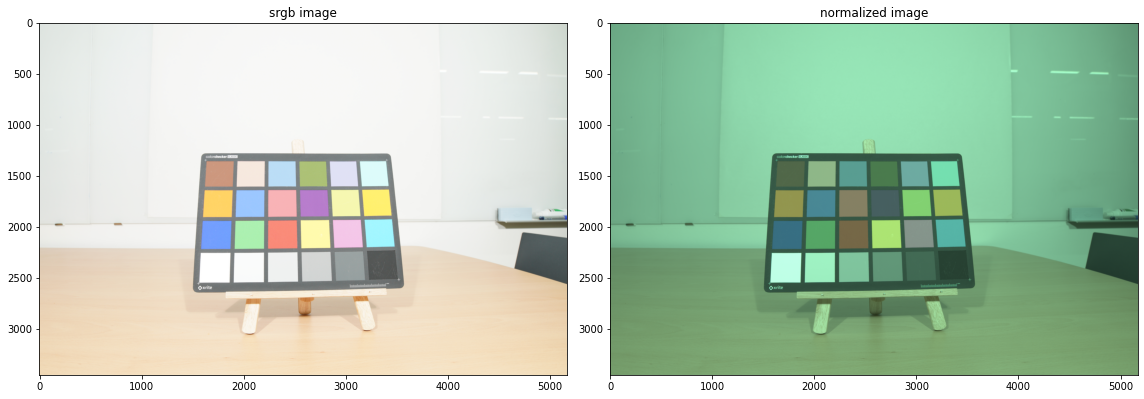

In [10]:
# for visualziation

img_normalize_demosaic = torch.nn.functional.pixel_shuffle(img_normalize.permute(2, 0, 1).unsqueeze(0), 2)
img_normalize_demosaic = demosaic.forward(img_normalize_demosaic, pattern='RGGB').squeeze(0).permute(1, 2, 0)
viz_two_images(a7r3_srgb, lin2rgb_pt(img_normalize_demosaic), 'srgb image', 'normalized image')

# White balance

```bash
WB RGGB Levels                  : 2576 1024 1024 1652
CFA Pattern                     : [Red,Green][Green,Blue]
```

In [11]:
wb_r = 2576/1024.0
wb_g = 1.0
wb_b = 1652/1024.0

bayer_pattern = 'RGGB'
# white balance
img_wb = WB_img(img_normalize, bayer_pattern, wb_r, wb_b)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


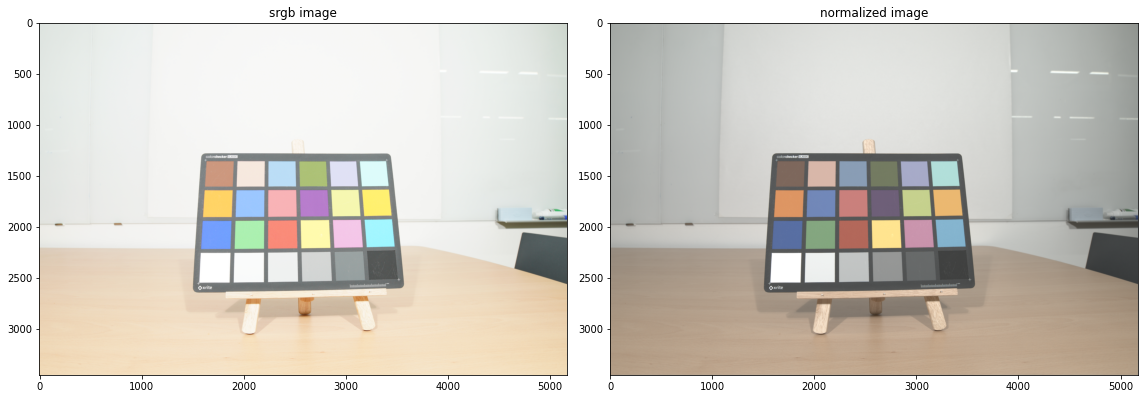

In [12]:
# for visualziation

img_wb_demosaic = torch.nn.functional.pixel_shuffle(img_wb.permute(2, 0, 1).unsqueeze(0), 2)
img_wb_demosaic = demosaic.forward(img_wb_demosaic, pattern='RGGB').squeeze(0).permute(1, 2, 0)
viz_two_images(a7r3_srgb, lin2rgb_pt(img_wb_demosaic), 'srgb image', 'normalized image')

# Demosaic

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


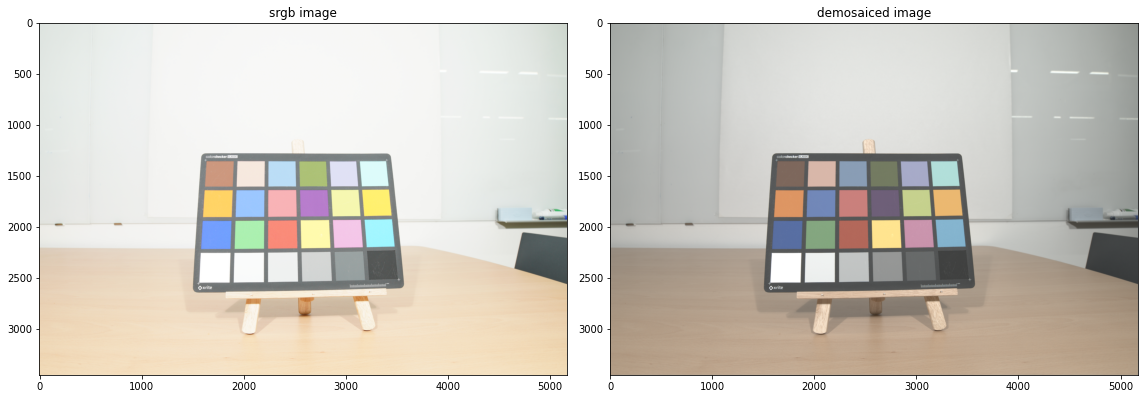

In [13]:

img_demosaic = torch.nn.functional.pixel_shuffle(img_wb.permute(2, 0, 1).unsqueeze(0), 2)
img_demosaic = demosaic.forward(img_demosaic, pattern=bayer_pattern).squeeze(0).permute(1, 2, 0)

viz_two_images(a7r3_srgb, lin2rgb_pt(img_demosaic), 'srgb image', 'demosaiced image')

# Color conversion (rawRGB2linearRGB)

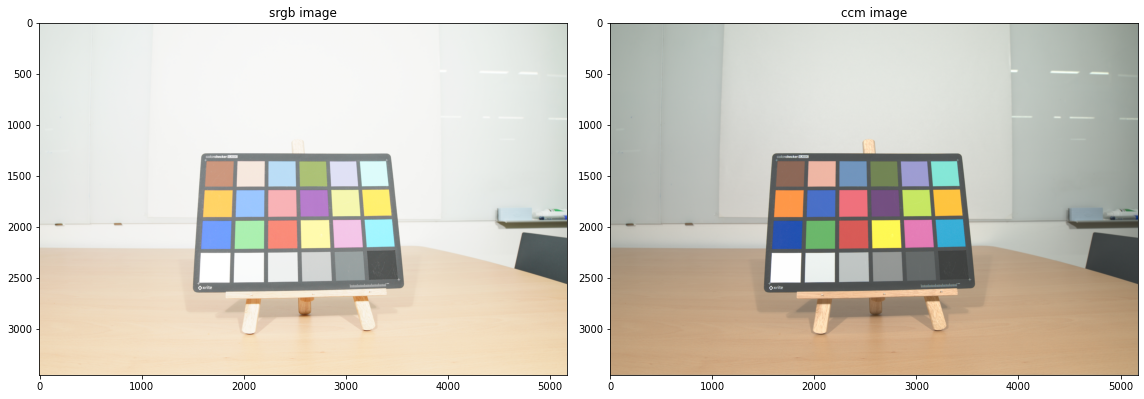

In [14]:
img_demosaic = img_demosaic.clamp(0, 1)
img_IXYZ = apply_cmatrix(img_demosaic, cam2xyz_realblur)

# frome XYZ to linear RGB
img_IL = xyz2lin(img_IXYZ)
img_IL = torch.clamp(img_IL, 0, 1)

viz_two_images(a7r3_srgb, lin2rgb_pt(img_IL), 'srgb image', 'ccm image')

### How to get color conversion matrix (ccm)?

1. Find ccm matrix from libraw library. (https://github.com/LibRaw/LibRaw/blob/2a9a4de21ea7f5d15314da8ee5f27feebf239655/src/tables/colordata.cpp)
2. Estimate ccm by yourself. (refer to Color conversion matrices in digital cameras: a tutorial.)

ILCE-7RM3, ILCE-7RM3A { 6640,-1847,-503,-5238,13010,2474,-993,1673,6527 }

### Notes
* ccm matrix from libraw is supposed to be normalized.

In [15]:
def normalize_ccm(libraw_xyz2cam):
    # refer to section 6.1 of Color conversion matrices in digital cameras: a tutorial. Rowland, Optical engineering 2020.
    
    # normalize ccm using white point of D65
    wp_d65_xyz = torch.tensor([0.9504, 1, 1.0888]);
    rgb_wp_d65 = apply_cmatrix(wp_d65_xyz[None,None,:], libraw_xyz2cam)

    c = rgb_wp_d65.max();

    libraw_xyz2cam = libraw_xyz2cam / c;
    
    # Convert ccm of D65 to ccm of auto white balanced images
    wp_rgb = torch.tensor([1.0, 1.0, 1.0]);
    wp_rgb_xyz = lin2xyz(wp_rgb[None,None,:])

    rgb = apply_cmatrix(wp_rgb_xyz[None,None,:], libraw_xyz2cam)
    D_inv = torch.diag(rgb.reshape(3))

    cam2xyz = torch.inverse(libraw_xyz2cam) @ D_inv
        
    return cam2xyz

libraw_xyz2cam = torch.tensor([6640, -1847, -503, -5238, 13010, 2474, -993, 1673, 6527]).reshape(3,3).float() / 10000
cam2xyz = normalize_ccm(libraw_xyz2cam)

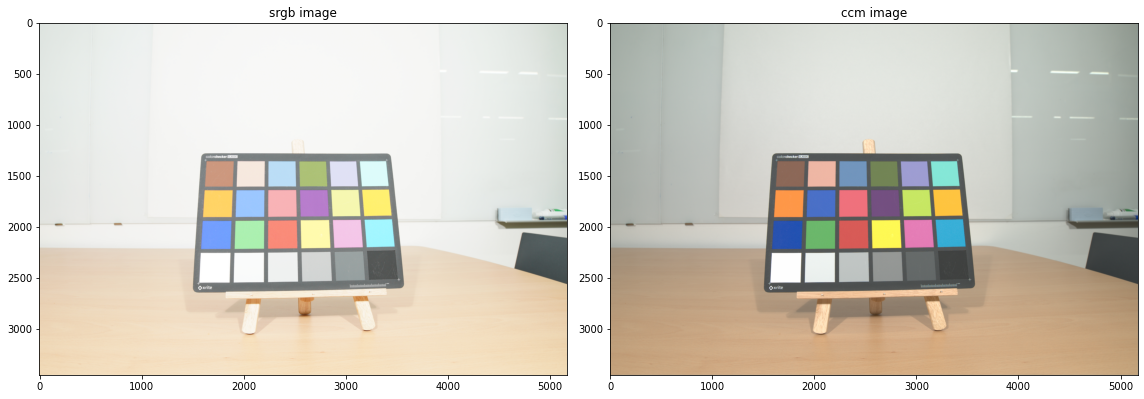

In [16]:
img_demosaic = img_demosaic.clamp(0, 1)
img_IXYZ = apply_cmatrix(img_demosaic, cam2xyz)

# frome XYZ to linear RGB
img_IL = xyz2lin(img_IXYZ)
img_IL = torch.clamp(img_IL, 0, 1)

viz_two_images(a7r3_srgb, lin2rgb_pt(img_IL), 'srgb image', 'ccm image')

# Camera Response Function (Non-linearity)

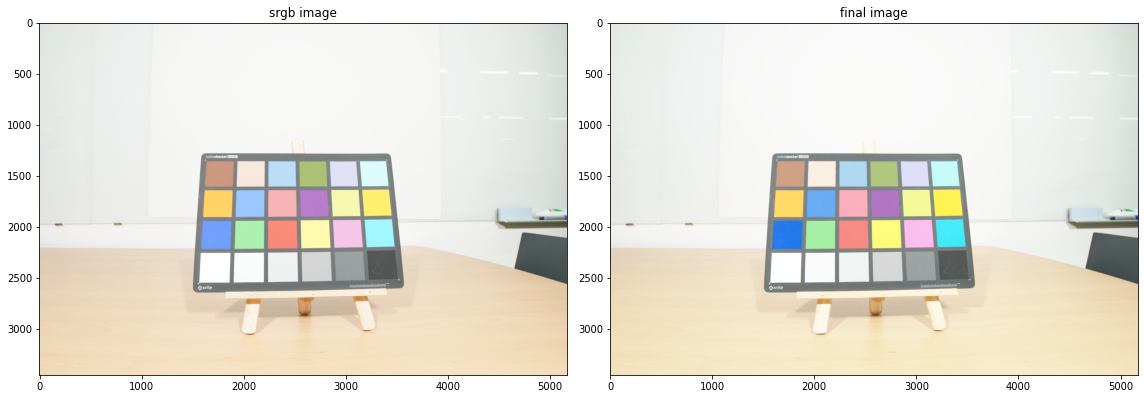

In [17]:
img_Irgb = lin2rgb_a7r3_polynomial(img_IL)
img_Irgb = torch.clamp(img_Irgb, 0, 1) # (h, w, c)

viz_two_images(a7r3_srgb, img_Irgb, 'srgb image', 'final image')

# How to estimate CRF
1. Capture color chart images (multiple images are better. We use 11 color chart images in the paper.)
2. Conduct polynomial regression between linear-RGB of raw image vs JPEG image of camera

# Detect color checker

In [18]:
#!pip install opencv-python==4.5.1.48

In [19]:
import colour
from colour_checker_detection import detect_colour_checkers_segmentation

image = a7r3_srgb
colour_checker_swatches_data_srgb = detect_colour_checkers_segmentation(image, additional_data=True)

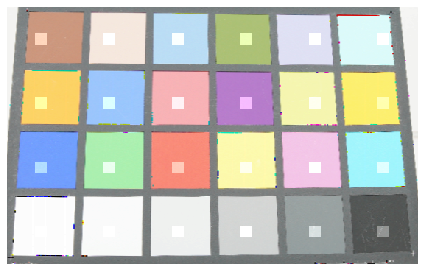

In [20]:
for colour_checker_swatches_data in colour_checker_swatches_data_srgb:
    swatch_colours, colour_checker_image, swatch_masks = (
        colour_checker_swatches_data)

    # Using the additional data to plot the colour checker and masks.
    masks_i = np.zeros(colour_checker_image.shape)
    for i, mask in enumerate(swatch_masks):
        masks_i[mask[0]:mask[1], mask[2]:mask[3], ...] = 1
    colour.plotting.plot_image(
            np.clip(colour_checker_image + masks_i * 0.25, 0, 1));

In [21]:
colour_checker_swatches_data_srgb = detect_colour_checkers_segmentation(a7r3_srgb, additional_data=True)
colour_checker_swatches_data_linrgb = detect_colour_checkers_segmentation(img_IL.numpy(), additional_data=True)

y = colour_checker_swatches_data_srgb[0].swatch_colours
x = colour_checker_swatches_data_linrgb[0].swatch_colours
x, y

(array([[ 0.2621337 ,  0.13884924,  0.0973274 ],
        [ 0.85818951,  0.47284269,  0.37438751],
        [ 0.16625838,  0.29958558,  0.50689813],
        [ 0.16918165,  0.23248315,  0.09077689],
        [ 0.34224568,  0.3396184 ,  0.64351853],
        [ 0.23418948,  0.79886635,  0.6787459 ],
        [ 0.99165822,  0.31164412,  0.06438856],
        [ 0.06891894,  0.16188225,  0.56977598],
        [ 0.86522013,  0.16597344,  0.20393503],
        [ 0.17350435,  0.07900972,  0.21761391],
        [ 0.57356239,  0.80031273,  0.12710507],
        [ 0.99221433,  0.55495569,  0.05111801],
        [ 0.02034262,  0.08483031,  0.43551449],
        [ 0.14729405,  0.47459907,  0.14683372],
        [ 0.68200684,  0.10381981,  0.09462625],
        [ 0.99221433,  0.94495396,  0.08778599],
        [ 0.78039303,  0.20459003,  0.46709233],
        [ 0.03870731,  0.42390226,  0.67659235],
        [ 0.99214482,  0.99214482,  0.9911021 ],
        [ 0.84527792,  0.8842299 ,  0.86371461],
        [ 0.52220398

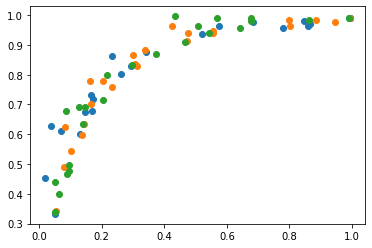

In [22]:
plt.scatter(x[:,0],y[:,0])
plt.scatter(x[:,1],y[:,1])
plt.scatter(x[:,2],y[:,2])

# Polynomial regression

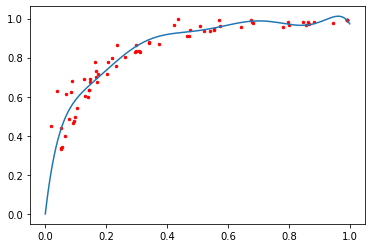

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


y = colour_checker_swatches_data_srgb[0].swatch_colours.flatten()
x = colour_checker_swatches_data_linrgb[0].swatch_colours.flatten()

# degree : 거듭제곱의 차수, include_bias : 편향값(1) 추가 여부
poly = PolynomialFeatures(degree=8, include_bias=False)

# 훈련 데이터셋 X_train 의 거듭제곱을 생성한 뒤, 훈련 데이터셋 X_train 에 새로운 변수로 추가
X_train_poly = poly.fit_transform(x[:, None])
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X_train_poly, y)

x_plot = np.linspace(0, 1, 200)
x_poly = poly.fit_transform(x_plot[:,None])
y_pred = lin_reg.predict(x_poly)
plt.plot(x_plot, y_pred)

#pred_our = lin2rgb_a7r3_polynomial(torch.tensor(x_plot))
#plt.plot(x_plot, pred_our)

plt.scatter(x.flatten(),y.flatten(),color='r',s=6)

# Monotonic polynomial regression

In [95]:
from polyfit import PolynomRegressor, Constraints

class PolynomRegressor_no_intercept(PolynomRegressor):
    
    def _build_designmatrix(self, x):
        n_samples, n_features = x.shape
        designmatrix = self._vander(x[:, 0])
        #loop over features and append Vandermonde matrix for each features without constant column
        for i in range(1, n_features):
            van = self._vander(x[:, i])
            designmatrix = np.hstack((designmatrix, van[:, 1:]))
        designmatrix[:,0] = np.zeros_like(designmatrix[:,0])
        return designmatrix

y = colour_checker_swatches_data_srgb[0].swatch_colours.flatten()
x = colour_checker_swatches_data_linrgb[0].swatch_colours.flatten()

polyestimator = PolynomRegressor_no_intercept(deg=8, regularization = 'l2', lam = 0.0, interactions=False)
monotone_constraint = Constraints(monotonicity='inc', constraint_range=[0, 1], gridpoints=20)
polyestimator.fit(x.flatten()[:,None], y.flatten(), loss = 'l2', constraints={0: monotone_constraint})

/home/jsrim/.pyenv/versions/3.7.7/envs/pytorch-1.4-mimo-unet/lib/python3.7/site-packages/cvxpy/problems/problem.py:1388: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


PolynomRegressor_no_intercept(deg=8, lam=0.0, regularization='l2')

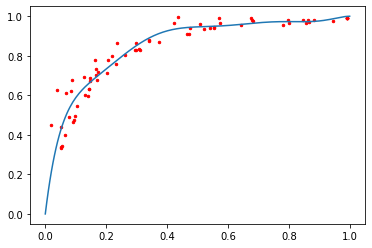

In [96]:
x_plot = np.linspace(0, 1, 200)
pred_mon = polyestimator.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, pred_mon)

#pred_our = lin2rgb_a7r3_polynomial(torch.tensor(x_plot))
#plt.plot(x_plot, pred_our)

plt.scatter(x.flatten(),y.flatten(),color='r',s=6)

In [97]:
pred_mon[1:] - pred_mon[:-1]

array([  6.13235298e-02,   5.60822209e-02,   5.12442995e-02,
         4.67857215e-02,   4.26834994e-02,   3.89156697e-02,
         3.54612615e-02,   3.23002649e-02,   2.94136002e-02,
         2.67830885e-02,   2.43914217e-02,   2.22221341e-02,
         2.02595739e-02,   1.84888759e-02,   1.68959340e-02,
         1.54673753e-02,   1.41905337e-02,   1.30534251e-02,
         1.20447220e-02,   1.11537298e-02,   1.03703631e-02,
         9.68512224e-03,   9.08907102e-03,   8.57381456e-03,
         8.13147773e-03,   7.75468422e-03,   7.43653596e-03,
         7.17059318e-03,   6.95085490e-03,   6.77173996e-03,
         6.62806849e-03,   6.51504389e-03,   6.42823531e-03,
         6.36356056e-03,   6.31726952e-03,   6.28592798e-03,
         6.26640198e-03,   6.25584253e-03,   6.25167086e-03,
         6.25156402e-03,   6.25344098e-03,   6.25544911e-03,
         6.25595112e-03,   6.25351237e-03,   6.24688862e-03,
         6.23501418e-03,   6.21699044e-03,   6.19207478e-03,
         6.15966996e-03,

# Using two color chart images

In [315]:
def raw2Lin(image, wb_r, wb_b):
    
    image = torch.from_numpy(image.copy().astype('float32'))
    
    red = image[0::2, 0::2]
    green_red = image[0::2, 1::2]
    green_blue = image[1::2, 0::2]
    blue = image[1::2, 1::2]

    img_raw = torch.stack([red, green_red, green_blue, blue], dim=2)
    
    # normalize
    black_level = 512
    white_level = 15360

    img_normalize = (img_raw - black_level) / (white_level - black_level)
    
    # White balance
    bayer_pattern = 'RGGB'
    # white balance
    img_wb = WB_img(img_normalize, bayer_pattern, wb_r, wb_b)
    
    img_demosaic = torch.nn.functional.pixel_shuffle(img_wb.permute(2, 0, 1).unsqueeze(0), 2)
    img_demosaic = demosaic.forward(img_demosaic, pattern=bayer_pattern).squeeze(0).permute(1, 2, 0)
    
    img_demosaic = img_demosaic.clamp(0, 1)
    img_IXYZ = apply_cmatrix(img_demosaic, cam2xyz_realblur)

    # frome XYZ to linear RGB
    img_IL = xyz2lin(img_IXYZ)
    img_IL = torch.clamp(img_IL, 0, 1)
    
    return img_IL

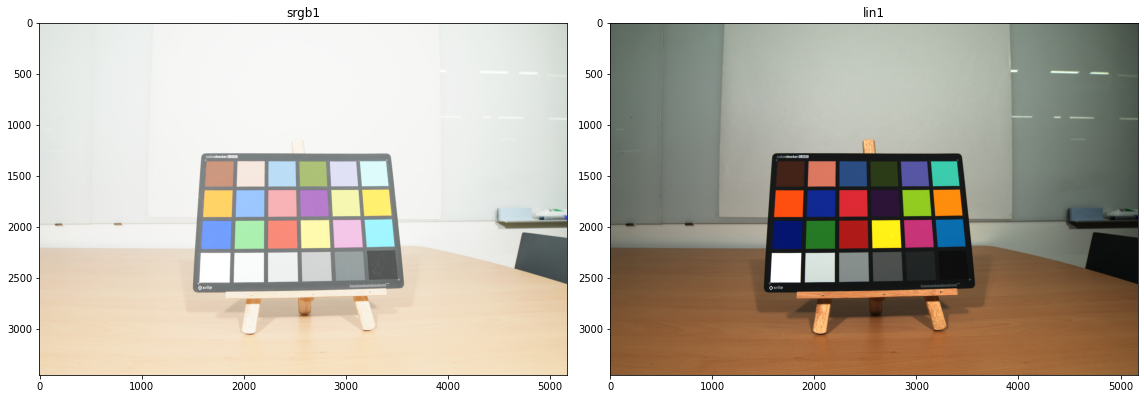

In [316]:
raw_path1 = 'notebooks/samples/CLN00001.ARW'
a7r3_raw1 = rawpy.imread(raw_path1).raw_image_visible.copy()[8:-8, 8:-8]
a7r3_lin1 = raw2Lin(a7r3_raw1,2576/1024.0, 1652/1024.0)

srgb_path1 = 'notebooks/samples/CLN00001.JPG'
a7r3_srgb1 = cv2.cvtColor(cv2.imread(srgb_path1, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB).astype('float32')/255

viz_two_images(a7r3_srgb1, a7r3_lin1, 'srgb1', 'lin1')

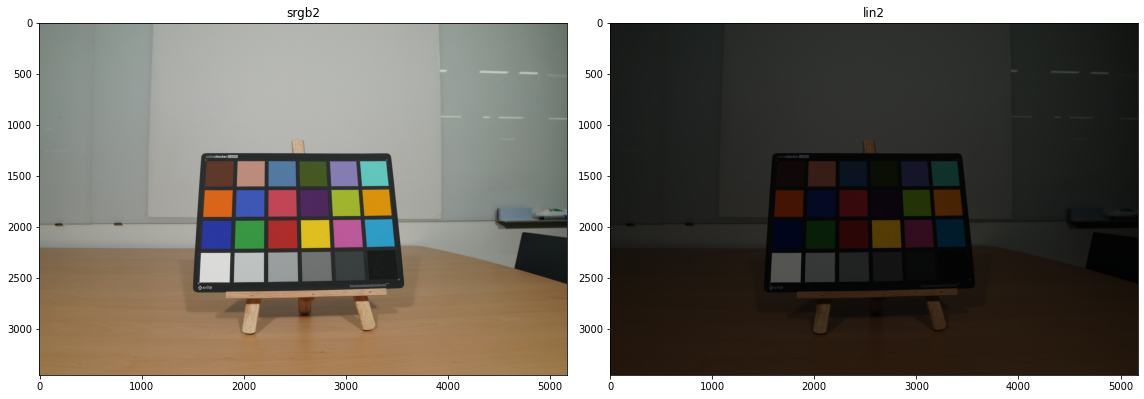

In [317]:
raw_path2 = 'notebooks/samples/CLN00007.ARW'
a7r3_raw2 = rawpy.imread(raw_path2).raw_image_visible.copy()[8:-8, 8:-8]
a7r3_lin2 = raw2Lin(a7r3_raw2,2576/1024.0, 1652/1024.0)

srgb_path2 = 'notebooks/samples/CLN00007.JPG'
a7r3_srgb2 = cv2.cvtColor(cv2.imread(srgb_path2, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB).astype('float32')/255

viz_two_images(a7r3_srgb2, a7r3_lin2, 'srgb2', 'lin2')

In [318]:
colour_checker_data_srgb1 = detect_colour_checkers_segmentation(a7r3_srgb1, additional_data=True)
colour_checker_data_linrgb1 = detect_colour_checkers_segmentation(a7r3_lin1.numpy(), additional_data=True)

y1 = colour_checker_data_srgb1[0].swatch_colours
x1 = colour_checker_data_linrgb1[0].swatch_colours

colour_checker_data_srgb2 = detect_colour_checkers_segmentation(a7r3_srgb2, additional_data=True)
colour_checker_data_linrgb2 = detect_colour_checkers_segmentation(a7r3_lin2.numpy(), additional_data=True)

y2 = colour_checker_data_srgb2[0].swatch_colours
x2 = colour_checker_data_linrgb2[0].swatch_colours

x = np.concatenate([x1, x2], axis=0)
y = np.concatenate([y1, y2], axis=0)

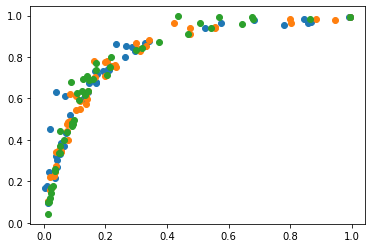

In [319]:
plt.scatter(x[:,0],y[:,0])
plt.scatter(x[:,1],y[:,1])
plt.scatter(x[:,2],y[:,2])

In [320]:
polyestimator = PolynomRegressor_no_intercept(deg=8, regularization = 'l2', lam = 0.0, interactions=False)
monotone_constraint = Constraints(monotonicity='inc', constraint_range=[0, 1], gridpoints=20)
polyestimator.fit(x.flatten()[:,None], y.flatten(), loss = 'l2', constraints={0: monotone_constraint})

PolynomRegressor_no_intercept(deg=8, lam=0.0, regularization='l2')

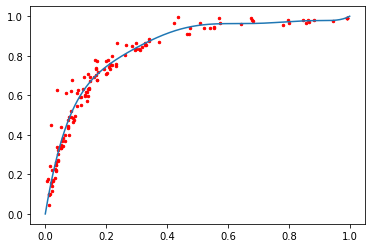

In [321]:
x_plot = np.linspace(0, 1, 1000)
pred_mon = polyestimator.predict(x_plot.reshape(-1, 1))
plt.plot(x_plot, pred_mon)

#pred_our = lin2rgb_a7r3_polynomial(torch.tensor(x_plot))
#plt.plot(x_plot, pred_our)

plt.scatter(x.flatten(),y.flatten(),color='r',s=6)